# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

 

## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

## Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary:
LABELS | DESCRIPTION
-------|:------------
 `Sl_No`| Primary key of the records
 `Customer Key`| Customer identification number
 `Average Credit Limit`| Average credit limit of each customer for all credit cards
 `Total credit cards`| Total number of credit cards possessed by the customer
 `Total visits bank`| Total number of visits that customer made (yearly) personally to the bank
 `Total visits online`| Total number of visits or online logins made by the customer (yearly)
 `Total calls made`| Total number of calls made by the customer to the bank or its customer service department (yearly)

# Initial Setup

In [150]:
#pip install pandas-profiling tabulate openpyxl

## Libraries

In [151]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs


# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA

# Pandas dataframe options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth',400)


# set the background for the graphs
plt.style.use('ggplot')

# For pandas profiling
from pandas_profiling import ProfileReport

# Printing style
from tabulate import tabulate

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [152]:
credit_data = pd.read_excel('Credit+Card+Customer+Data.xlsx')

In [153]:
data = credit_data.copy()

# Dataset Summary

## Shape of the data

In [154]:
print('There are {row} records, and {col} columns in the dataset'.format(row=data.shape[0], col=data.shape[1]))

There are 660 records, and 7 columns in the dataset


## Missing Values

In [155]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There are no missing values in the dataset

## Duplicate data

In [156]:
data.duplicated().sum()

0

- There are no duplicate records

In [157]:
# First 10 rows of data
data.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


## Data Types

In [158]:
data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

- All the attributes are integers

In [159]:
data = data.set_index(['Sl_No'])

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB


In [161]:
data['Customer Key'].nunique()

655

In [162]:
data['Customer Key'].value_counts()

97935    2
50706    2
47437    2
37252    2
96929    2
        ..
73811    1
72892    1
51773    1
96163    1
80150    1
Name: Customer Key, Length: 655, dtype: int64

- Earlier we said there are no duplicate keys. But now,it seems that there are 5 duplicates in the customer key correspoding to `customer_key` 97935, 50706, 47437, 37252, 96929.    
- We will investiagte it further.

## Analyzing the records with duplicate customer keys

In [163]:
data[data['Customer Key'].isin(data[data['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
105,97935,17000,2,1,2,10


- The column records for same Customer Key look different from each other. 
- I am assuming this is probably a mistake in the Customer Key assignment.
- So, we may also consider them as two different customers. 
- After the clustering, I will analyze the groups corresponding to these sets of records.

## Standardizing Column Names

In [164]:
def feature_name_standardize(df: pd.DataFrame):
    df_ = df.copy()
    df_.columns = [i.replace(" ", "_").lower() for i in df_.columns]
    return df_

In [165]:
data = feature_name_standardize(data)

## Data Summary

In [166]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
customer_key,660.000,55141.444,25627.772,11265.000,33825.250,53874.500,77202.500,99843.000
avg_credit_limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
total_credit_cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


- Mean value for `customer_key` is 55141.
- Max value for `avg_credit_limit` is 200k.
- Min and Max value for `total_credit_cards` is 1 and 10 respectively.
- Min and Max value for `total_calls_made` is 0 and 10 respectively.


# Exploratory Data Analysis

## Univariate Analysis

In [167]:
def boxplot_histogram(feature, figsize=(10, 7), bins=None):
    """ 
    Combine Boxplot and histogram
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    

    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='dashdot');# Add median to the histogram
    

In [168]:
def summary(data: pd.DataFrame, x: str):

    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    
    dict={'Min': x_min, 'Q1': Q1, 'Q2': Q2, 'Q3': Q3, 'Max': x_max}
    df = pd.DataFrame(data=dict, index=['Value'])
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n')
    print(tabulate(df, headers = 'keys', tablefmt = 'grid'))

### Analysis of `customer_key`

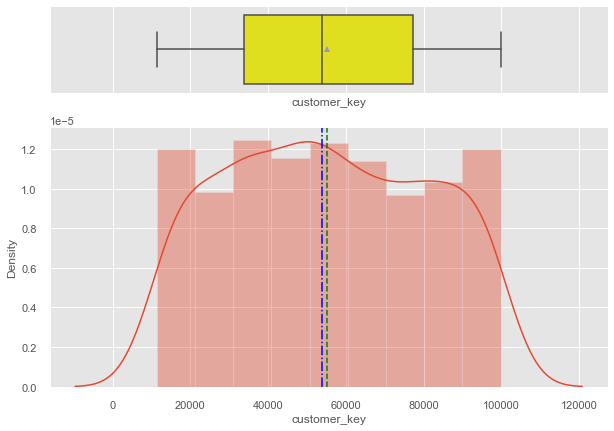

In [169]:
boxplot_histogram(data["customer_key"])

In [170]:
summary(data,'customer_key')

5 Point Summary of Customer_key Attribute:

+-------+-------+---------+---------+---------+-------+
|       |   Min |      Q1 |      Q2 |      Q3 |   Max |
+=======+=======+=========+=========+=========+=======+
| Value | 11265 | 33825.2 | 53874.5 | 77202.5 | 99843 |
+-------+-------+---------+---------+---------+-------+


- There is no outlier
- Since, mean and median is almost same, so `customer_key` is almost normal distributed.

### Summary of average credit limit

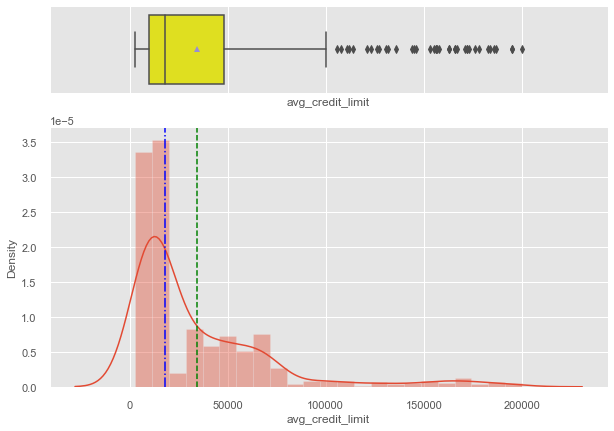

In [171]:
boxplot_histogram(data["avg_credit_limit"])

In [172]:
summary(data,'avg_credit_limit')

5 Point Summary of Avg_credit_limit Attribute:

+-------+-------+-------+-------+-------+--------+
|       |   Min |    Q1 |    Q2 |    Q3 |    Max |
+=======+=======+=======+=======+=======+========+
| Value |  3000 | 10000 | 18000 | 48000 | 200000 |
+-------+-------+-------+-------+-------+--------+


- The attribute is right skewed with a lot of outliers
- Min is 3k and  max is 200k.

### Summary of total credit cards

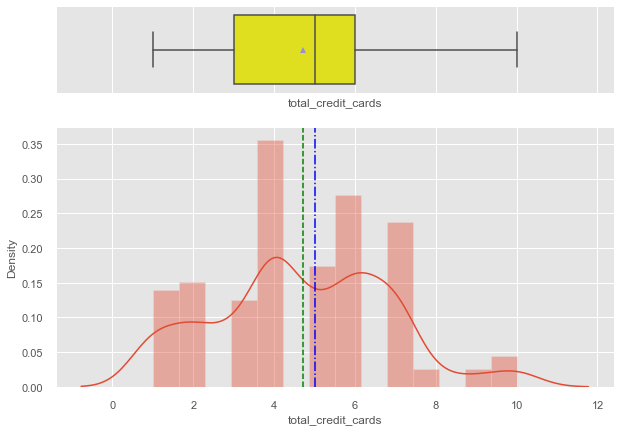

In [173]:
boxplot_histogram(data["total_credit_cards"]) 

In [174]:
summary(data,'total_credit_cards')

5 Point Summary of Total_credit_cards Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
+=======+=======+======+======+======+=======+
| Value |     1 |    3 |    5 |    6 |    10 |
+-------+-------+------+------+------+-------+


- This attribute doesn't have outliers.
- Since, mean is smaller than median, so it is left skewed.

### Summary of total bank visit

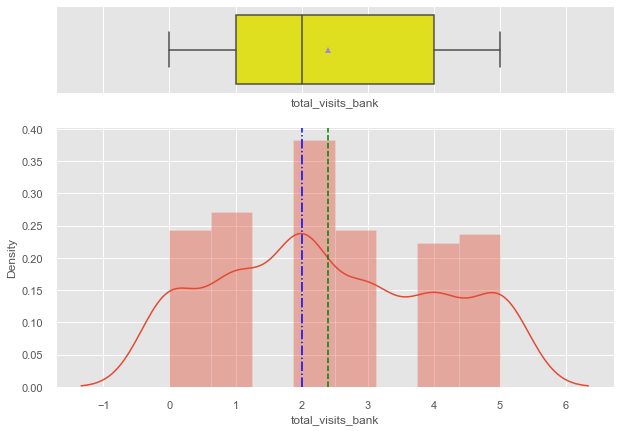

In [175]:
boxplot_histogram(data["total_visits_bank"])

In [176]:
summary(data, 'total_visits_bank')

5 Point Summary of Total_visits_bank Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
+=======+=======+======+======+======+=======+
| Value |     0 |    1 |    2 |    4 |     5 |
+-------+-------+------+------+------+-------+


- Doesn't have outliers.
- It is right skewed.

### Summary of total_visits_online

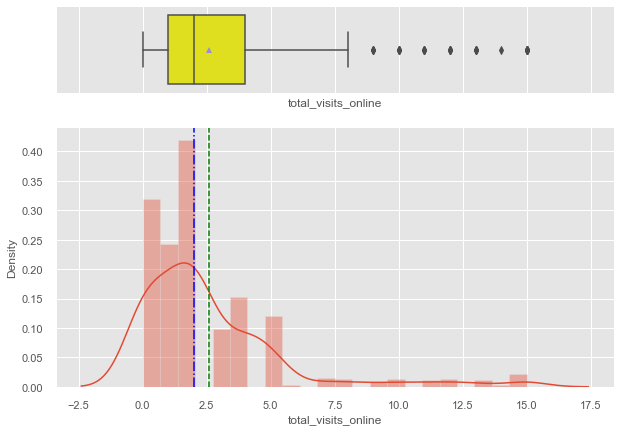

In [177]:
boxplot_histogram(data["total_visits_online"])

In [178]:
summary(data, 'total_visits_online')

5 Point Summary of Total_visits_online Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
+=======+=======+======+======+======+=======+
| Value |     0 |    1 |    2 |    4 |    15 |
+-------+-------+------+------+------+-------+


- It has outliers at the right end of the plot.
- It is right skewed.

### Summary of Total Calls Made to the Bank

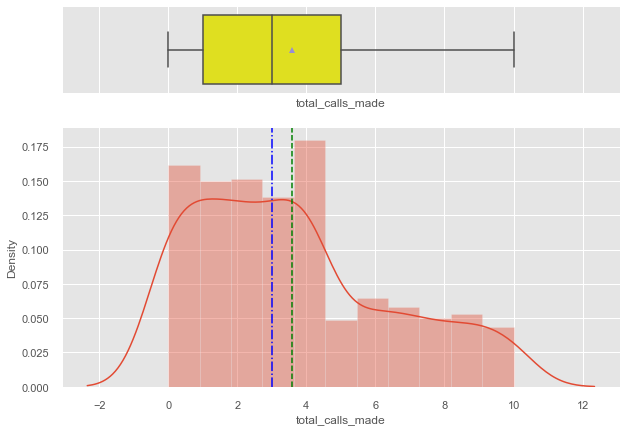

In [179]:
boxplot_histogram(data["total_calls_made"])

In [180]:
summary(data, 'total_calls_made')

5 Point Summary of Total_calls_made Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
+=======+=======+======+======+======+=======+
| Value |     0 |    1 |    3 |    5 |    10 |
+-------+-------+------+------+------+-------+


- No outliers, and right skewed.

In [181]:
print('We will check the summary of below columns: \n', data.columns.tolist())


We will check the summary of below columns: 
 ['customer_key', 'avg_credit_limit', 'total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']


## Labeled Bar-plots

> Creating a function to plot labeled bar plot of the features, with percentage label on data bars.

In [182]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=18)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="twilight_shifted",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

     # percentage of each class of the category
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            ) 
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=14,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

> Creating a credit card limit bin out of the available data in the avg credit limit feature

In [183]:
data['cc_spending_bin'] = pd.cut(data['avg_credit_limit'], bins=[3000,	10000,	18000, 	45000,	200000]
                                ,labels=['Very Low', 'Low', 'Mid', 'High'], include_lowest=True)


### Credit Card Limit Bins

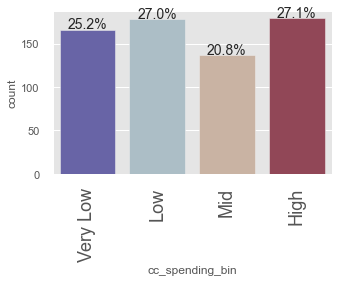

In [184]:
labeled_barplot(data, 'cc_spending_bin', perc=True)

### Total Credit Cards

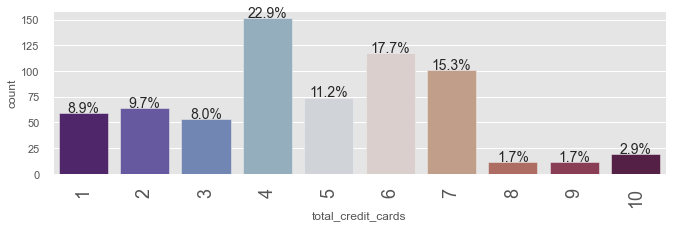

In [185]:
labeled_barplot(data, 'total_credit_cards', perc=True)

### Total Visits to the Bank

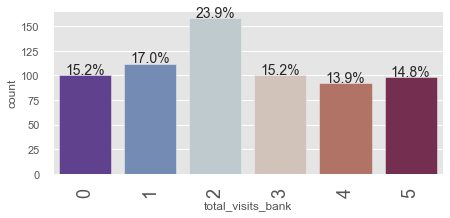

In [186]:
labeled_barplot(data, 'total_visits_bank', perc=True)

### Total Online Visits

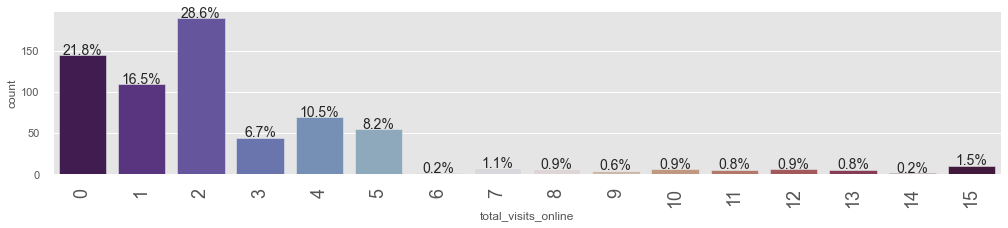

In [187]:
labeled_barplot(data, 'total_visits_online', perc=True)

### Total Calls Made

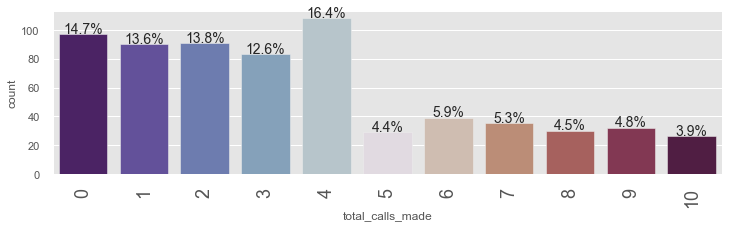

In [188]:
labeled_barplot(data, 'total_calls_made', perc=True)

## Bi-variate Analysis

### Pair Plot

<Figure size 1440x1440 with 0 Axes>

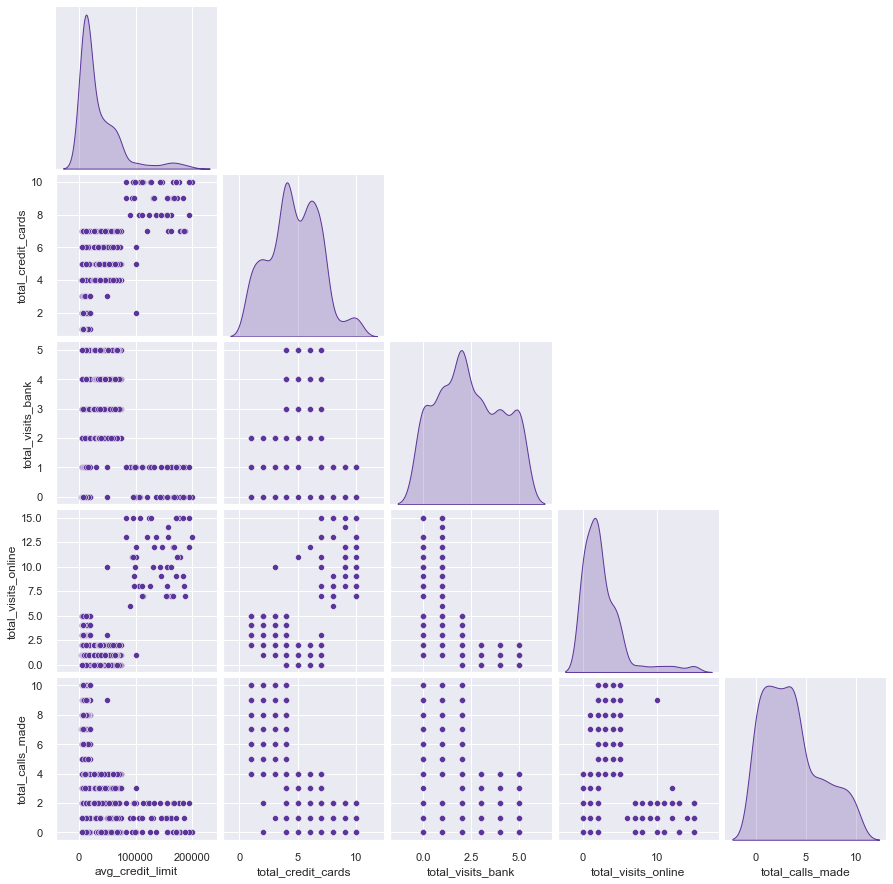

In [189]:
plt.figure(figsize=(20,20));
sns.set(palette="twilight_shifted");
sns.pairplot(data.iloc[:, 1:], diag_kind='kde', corner=True);

### Heatmap

In [190]:
data.corr()

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
customer_key,1.000,0.069,-0.010,-0.001,0.023,0.006
avg_credit_limit,0.069,1.000,0.609,-0.100,0.551,-0.414
total_credit_cards,-0.010,0.609,1.000,0.316,0.168,-0.651
total_visits_bank,-0.001,-0.100,0.316,1.000,-0.552,-0.506
total_visits_online,0.023,0.551,0.168,-0.552,1.000,0.127
total_calls_made,0.006,-0.414,-0.651,-0.506,0.127,1.000


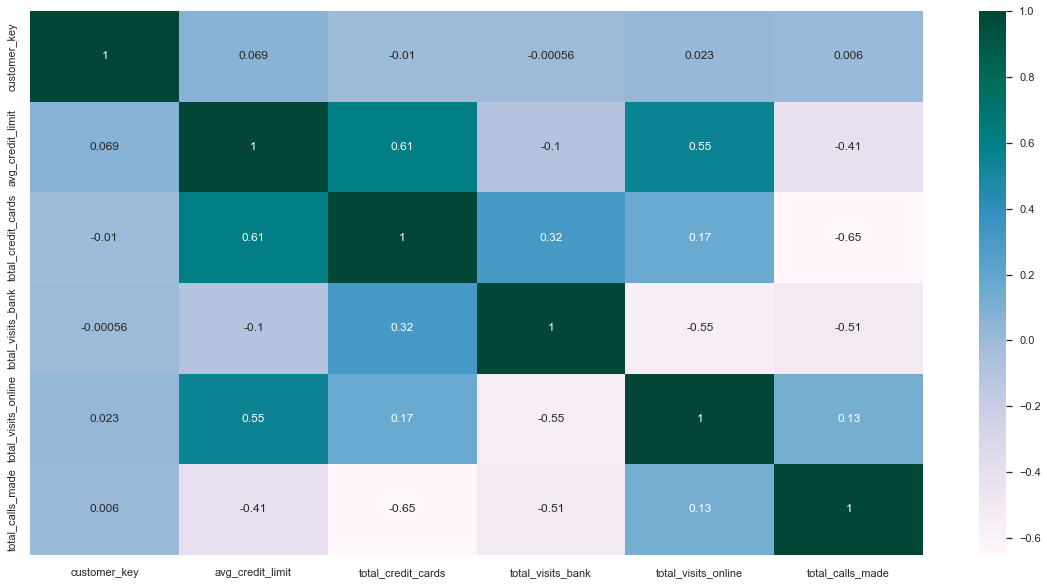

In [191]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap="PuBuGn");

 
 - `Total Credit Cards` and `Total Calls Made` are negatively correlated
 - `Total Visits Online` is also negatively correlated with `Total Visits to Bank`
 - `Average Credit Limit` has slightly positive correlation with `Total Credit Cards`
 - `Total Number of Visits Online` have slightly positive correlation with `Total Calls Made`

### Average Credit Limit distribution by Each of the Other Attributes

In [192]:
# Function to plot numerical feature by each category with target hue

def plot_numeric_by_category(data: pd.DataFrame, category_columns: list, numeric_column: str, hue: str = None):
    '''
    The function plots a numerical feature in box plot by every category column specified in the list, 
    with hue of a target category
    '''
    num_cols = 2
    num_rows = int(len(category_columns) /2 + 1)

    plt.figure(figsize=(20, 8*num_rows))
    for i, col in enumerate(category_columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.set(palette="twilight_shifted");
        sns.boxplot(data=data, x=col, y=numeric_column, hue=hue, showfliers=True).set(title = numeric_column + ' vs. ' + col );

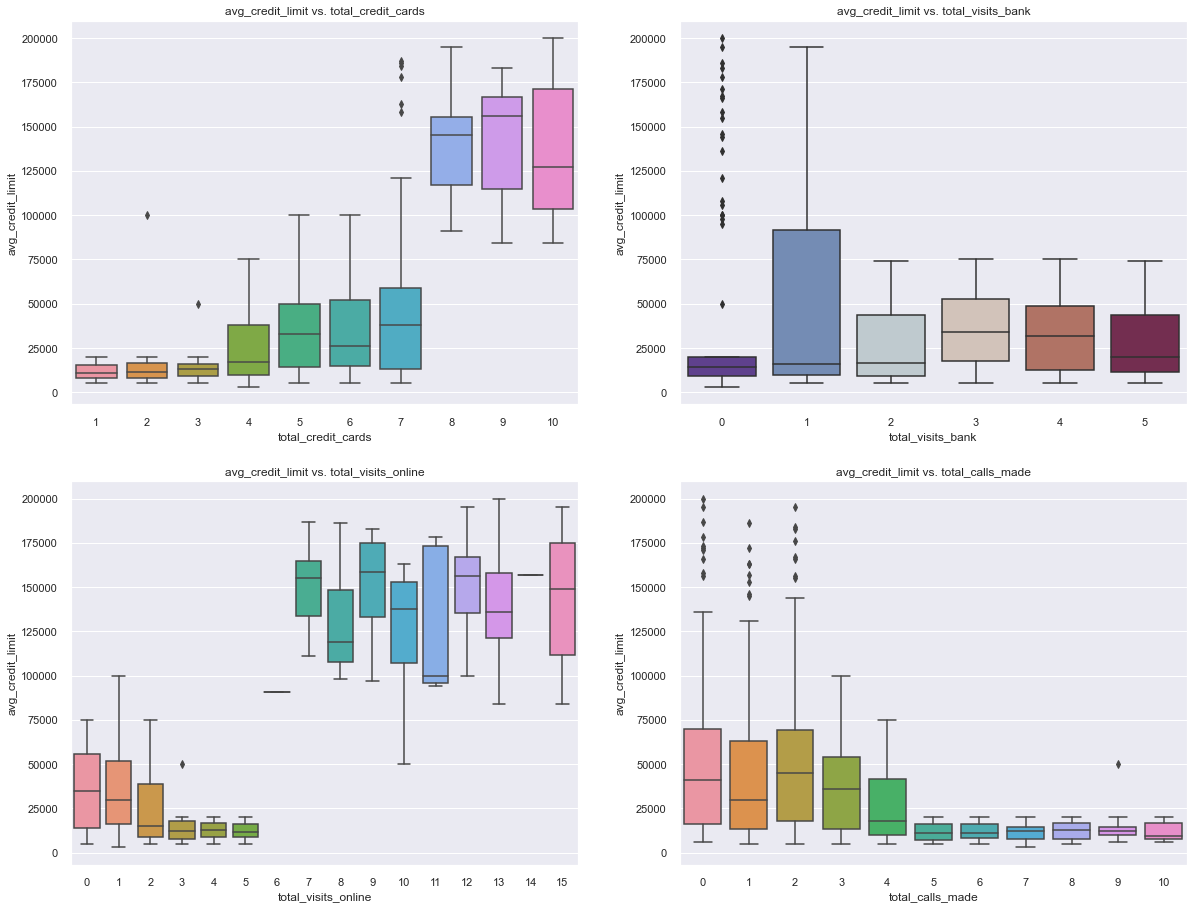

In [193]:
plot_numeric_by_category(data\
                    ,category_columns=['total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']\
                    ,numeric_column='avg_credit_limit')

- We can see clear segmentations with respect to each pair of features

# Data Preprocessing

 We should scale the data before using clustering algorithms, because, different scales of features would result in unintentional importance to the feature of higher scale while calculating the distances.

In [194]:
# scaling the dataset before clustering
data_copy = data.copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:,1:-1])

# K-means Clustering

## Finding the best numbr of centroids (K)

#### Elbow Curve to get the right number of Clusters

- A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters.
- The **Elbow Method** is one of the most popular methods to determine this optimal value of k.

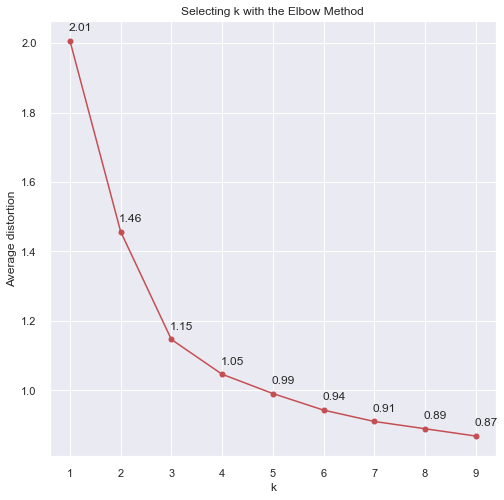

In [195]:
clusters = range(1, 10)
meanDistortions = []
plt.figure(figsize=(8, 8))
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction = model.predict(data_scaled)
    distortion = (
        sum(
            np.min(cdist(data_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / data_scaled.shape[0]
    )

    meanDistortions.append(distortion)


plt.plot(clusters, meanDistortions, "ro-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
for x,y in zip(clusters, meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

**Appropriate value for k seems to be 3**

**Let's check the silhouette scores.**

## Silhouette Scores

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

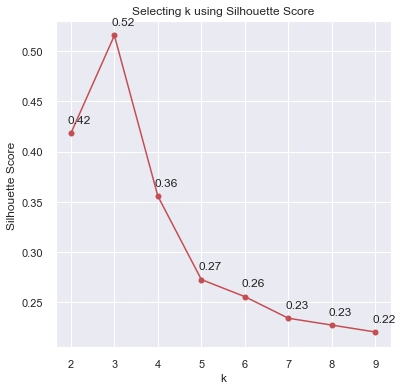

In [196]:
sil_score = []
cluster_list = list(range(2, 10))
plt.figure(figsize=(6, 6))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((data_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled, preds)
    sil_score.append(score)
    

plt.plot(cluster_list, sil_score, "ro-")
plt.xlabel("k")
plt.ylabel("Silhouette Score ")
plt.title("Selecting k using Silhouette Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

**Silhouette score for 3 clusters is highest. So, we will choose 3 as value of k.**

**Let's also visualize the silhouettes created by each of the clusters for two values of K, 3 and 4**

## Visualize the Silhouettes

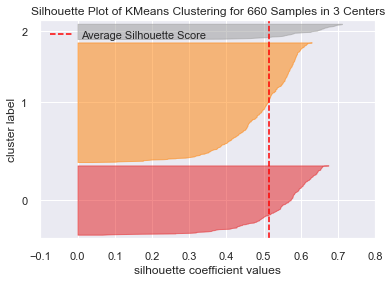

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [197]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

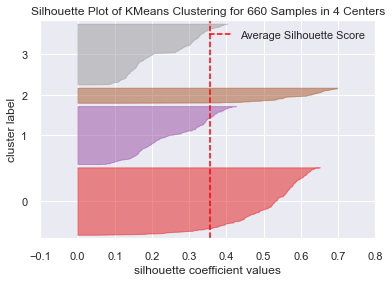

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [198]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

**Clearly, 3 clusters seem very reasonable for this case study**

## Build the model with 3 centroids

In [199]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=0)

## Add the cluster numbers as a new attribute in the dataset

In [200]:
# adding kmeans cluster labels to the original and scaled dataframes
data_scaled_df = pd.DataFrame(data_scaled, columns=data.iloc[:,1:-1].columns.unique().tolist())
data['cluster'] = kmeans.labels_
data_scaled_df['cluster'] = kmeans.labels_

## Customer Profiling - Visualize the Clusters with Features

<Figure size 1440x1872 with 0 Axes>

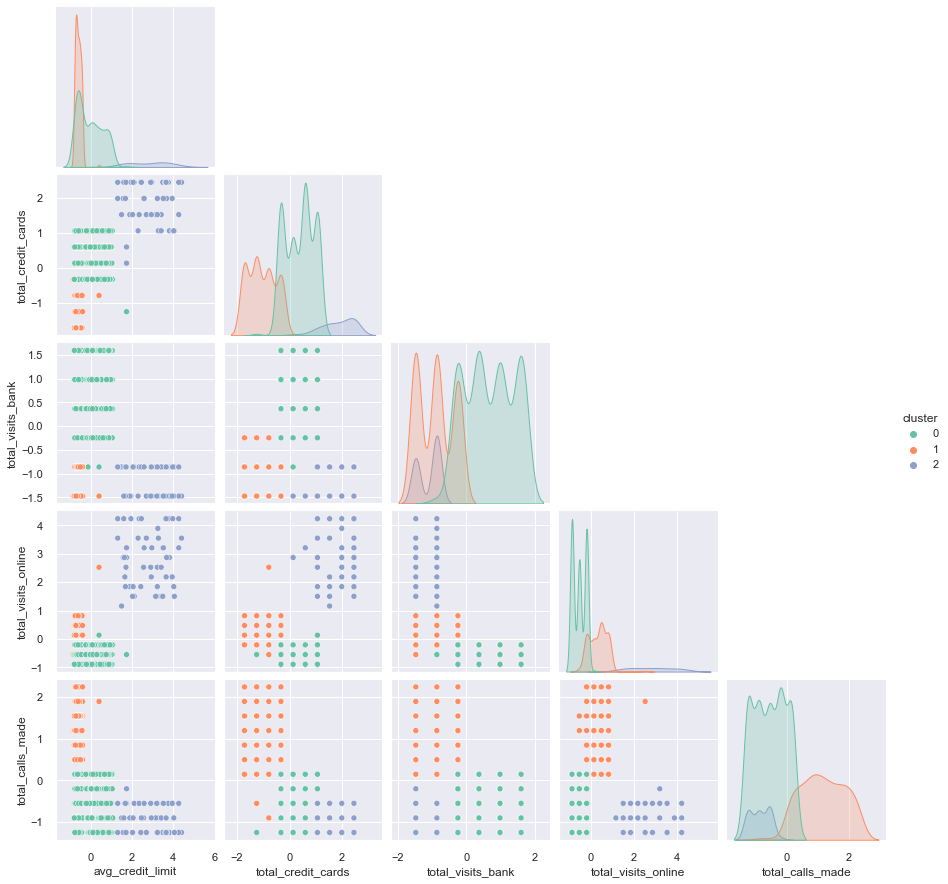

In [201]:
plt.figure(figsize=(20, 26))

sns.pairplot(data_scaled_df, diag_kind='kde', corner=True, hue='cluster', palette='Set2');

- It appears, the method of using bank services `(In Person/ Online/ Call)` drives the clustering mechanism predominantly.
- We will check whether this criteria of clustering is valid or not.
- We can clearly see 3 clusters whic is generally present in each attribute.

In [202]:
#pip install plotly

In [203]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= data['total_visits_bank'],
    y= data['total_visits_online'],
    z= data['total_calls_made'],
    mode='markers',
     marker=dict(
        color = data['cluster'], 
        size= 20,
        line=dict(
            color= data['cluster'],
            width= 15
        ),
        opacity=0.75
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Bank Visits'),
            yaxis = dict(title  = 'Online Visits'),
            zaxis = dict(title  = 'Call Customer Service')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)

In [204]:
trace1 = go.Scatter3d(
    x= data['total_visits_bank'],
    y= data['total_visits_online'],
    z= data['total_credit_cards'],
    mode='markers',
     marker=dict(
        color = data['cluster'], 
        size= 20,
        line=dict(
            color= data['cluster'],
            width= 15
        ),
        opacity=0.75
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Bank Visits'),
            yaxis = dict(title  = 'Online Visits'),
            zaxis = dict(title  = 'Total Credit Cards')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)

<AxesSubplot:xlabel='avg_credit_limit', ylabel='total_credit_cards'>

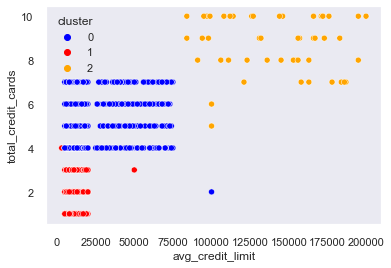

In [205]:
sns.set(style='dark')
sns.scatterplot(x=data['avg_credit_limit'], y=data['total_credit_cards'], hue=data['cluster'], palette=['blue', 'red', 'orange'])

In [206]:
cluster_profile = data.iloc[:,1:].groupby('cluster').mean()
cluster_profile['count_of_customers'] = data.groupby('cluster')['customer_key'].count()

cluster_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
cluster,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


## Analyzing the segments using Box Plot

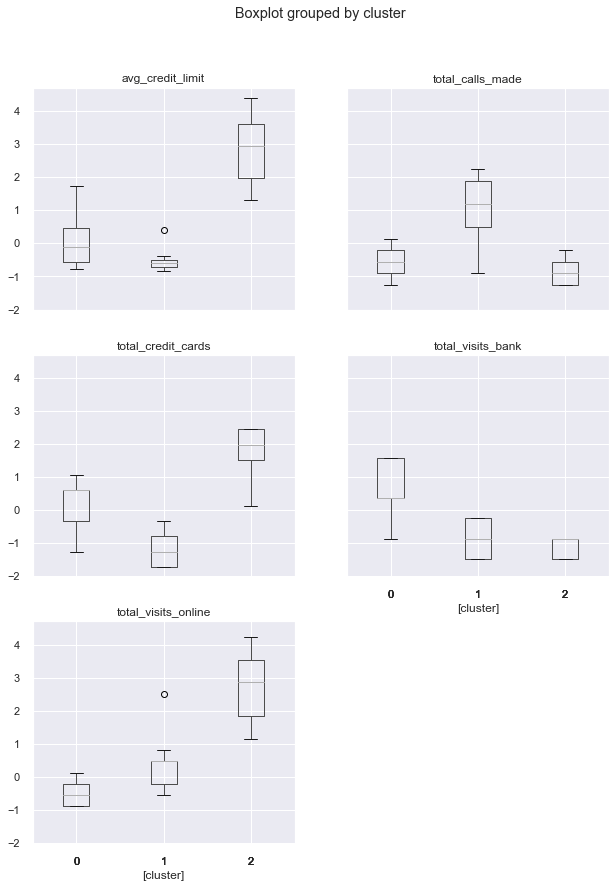

In [207]:
data_scaled_df.boxplot(by='cluster', layout=(3,2), figsize=(10,14));

- Cluster 0 - The customers who prefer in-person interactions tend to have the mid-range of credit cards and credit limit. 
- Cluster 1 - The customers who contact via phonecall are in another segment, who have lowest credit limit and number of cards.
- Cluster 2 - Customers who prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards. 



# Hierarchical Clustering

Before starting clustering we'll remove the cluster column from the dataset.

In [208]:
k_means_clusters = data_scaled_df['cluster']
data_scaled_df.drop(columns=['cluster'], inplace=True)

I am going to try many distance metrics and linkage methods to find the best combination.

## Cophenetic Correlations


In [209]:
# list of distance metrics
distance_metrics = [ 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski']

# list of linkage methods
linkage_methods = ['complete', 'average', 'single', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Canberra distance and complete linkage is 0.46069443891594597.
Cophenetic correlation for Canberra distance and average linkage is 0.6751521558776901.
Cophenetic correlation for Canberra distance and single linkage is 0.7566178713003985.
Cophenetic correlation for Canberra distance and weighted linkage is 0.5351232761249246.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Cityblock distance and complete linkage is 0.8731477899179829.
Cophenetic correlation for Cityblock distance and average linkage is 0.896329431104133.
Cophenetic correlation for Cityblock distance and single linkage is 0.7252379350252723.
Cophenetic correlation 

In [210]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


In [211]:
distance_metrics = [ 'euclidean']

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.8939385846326323.
Cophenetic correlation for Euclidean distance and ward linkage is 0.7415156284827493.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.


**We see that the cophenetic correlation is maximum with `Euclidean distance` and `Average Linkage`.**

**Let's see the dendrograms for the different linkage methods.**

## Dendograms

A dendrogram, in general, is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters. 

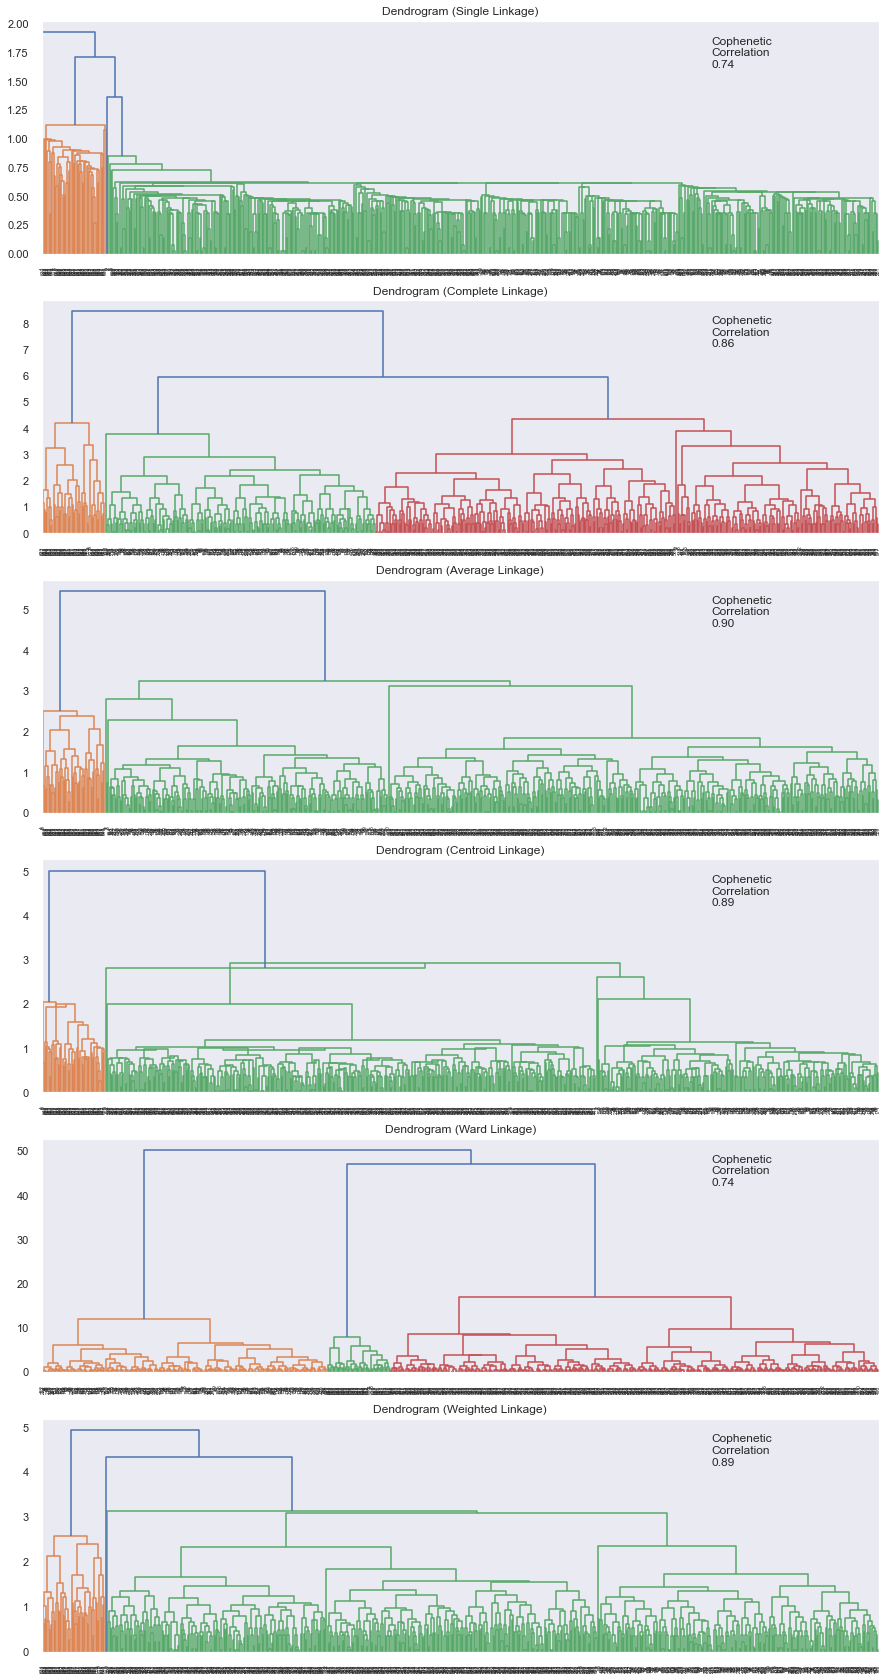

In [212]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

>- The `cophenetic correlation` is `highest for average linkage methods`.
>- `3` appears to be the appropriate `number of clusters` from the dendrogram for average linkage.

## Build Agglomerative Clustering model

Also known as bottom-up approach or hierarchical agglomerative clustering (HAC). Bottom-up algorithms treat each data as a singleton cluster at the outset and then successively agglomerates pairs of clusters until all clusters have been merged into a single cluster that contains all data. 

### Build Model

In [213]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

### Assign cluster labels

In [214]:
data_scaled_df['hc_cluster'] = HCmodel.labels_
data['hc_cluster'] = HCmodel.labels_

### Cluster profile

In [215]:
cluster_profile_hc = data.iloc[:,1:].groupby('hc_cluster').mean()
cluster_profile_hc['count_of_customers'] = data.groupby('hc_cluster')['customer_key'].count()

cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster,count_of_customers
hc_cluster,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


### Analyzing the segments using Box Plot

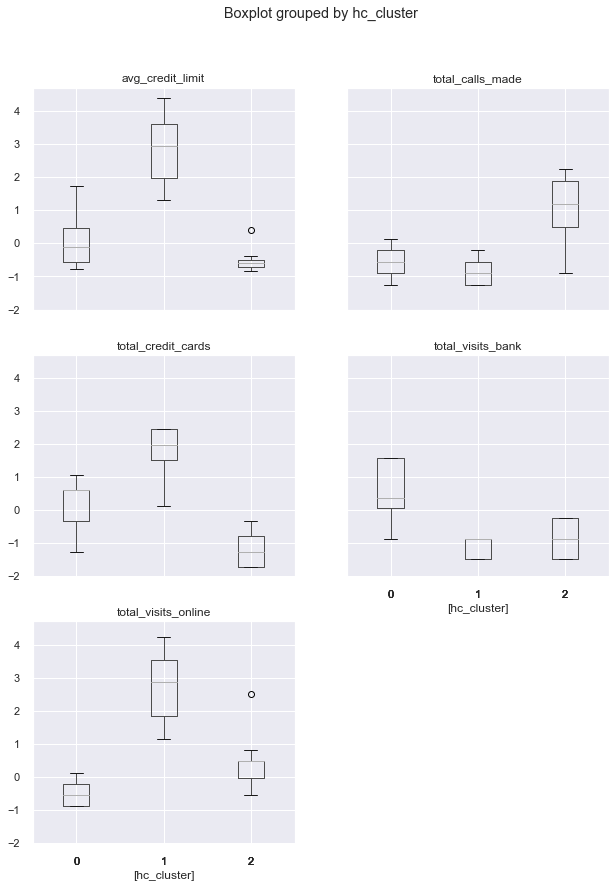

In [216]:

data_scaled_df.boxplot(by='hc_cluster', layout=(3,2), figsize=(10,14));

- Cluster 0 - The customers who prefer in-person interactions tend to have the mid-range of credit cards and credit limit. 
-  Cluster 1 - Customers who prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards.
- Cluster 2 - The customers who contact via phonecall are in another segment, who have lowest credit limit and number of cards.

### Checking the clusters for the duplicated customer keys

In [217]:
data[data['customer_key'].isin(data[data['customer_key'].duplicated()]['customer_key'].tolist())].sort_values('customer_key')

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cc_spending_bin,cluster,hc_cluster
Sl_No,,,,,,,,,
49,37252,6000,4,0,2,8,Very Low,1,2
433,37252,59000,6,2,1,2,High,0,0
5,47437,100000,6,0,12,3,High,2,1
333,47437,17000,7,3,1,0,Low,0,0
412,50706,44000,4,5,0,2,Mid,0,0
542,50706,60000,7,5,2,2,High,0,0
392,96929,13000,4,5,0,0,Low,0,0
399,96929,67000,6,2,2,2,High,0,0
105,97935,17000,2,1,2,10,Low,1,2


- If we consider the duplicate records are actually updated records for the same customer, then it can be observed that 3 of the 5 customers have actually changed their clusters/groups. It appears, providing credit limit increase, or turning the customers to digital banking customers, we can actually move the customers to a more desirable and profitable cluster.

## PCA for Dimensionality Reduction

**Although there are only 5 dimensions, it'll be really cool to be able to visualize the clusters at 3 dimensional space without loosing much of the information. Let's use PCA to reduce the dimensions so that 90% of the variance in the data is explained.**

In [218]:
data_scaled_df_pca = data_scaled_df.drop('hc_cluster', axis=1).copy()

In [219]:
pca = PCA()
pca.fit(data_scaled_df_pca)

PCA()

**Let's check the variance explained by individual components.**

In [220]:
pca.explained_variance_ratio_

array([0.45736578, 0.37426483, 0.06401348, 0.0555688 , 0.04878711])

Text(0, 0.5, 'Cumulative Explained Variance')

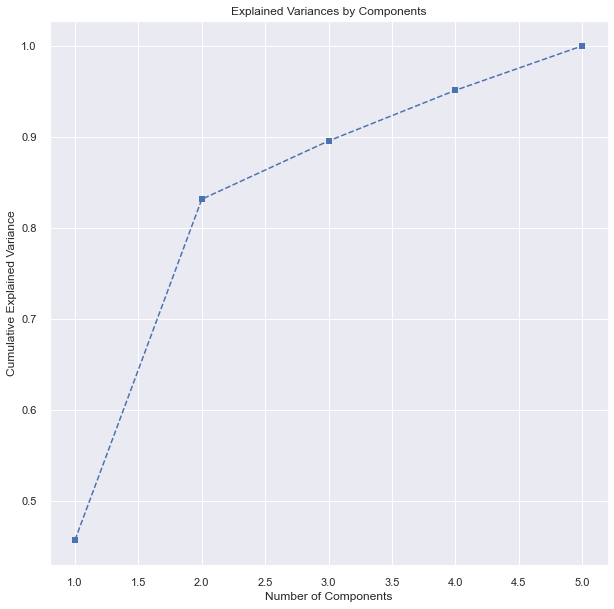

In [221]:
# visualizing the variance explained by individual principal components
sns.set(style='darkgrid')
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 6), pca.explained_variance_ratio_.cumsum(), marker="s", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

**For 90% variance explained, the number of components looks to be 3.**

In [222]:
pca = PCA(
    n_components=3, svd_solver="full"
)  # svd_solver=full helps in faster convergence in case of very large data set
pca.fit(data_scaled_df_pca)

PCA(n_components=3, svd_solver='full')

In [223]:
# checking the variance explained by individual components.
print('Explained variance = {var} %'.format(var=round(pca.explained_variance_ratio_.sum(),2)*100))

Explained variance = 90.0 %


Text(0, 0.5, 'Cumulative Explained Variance')

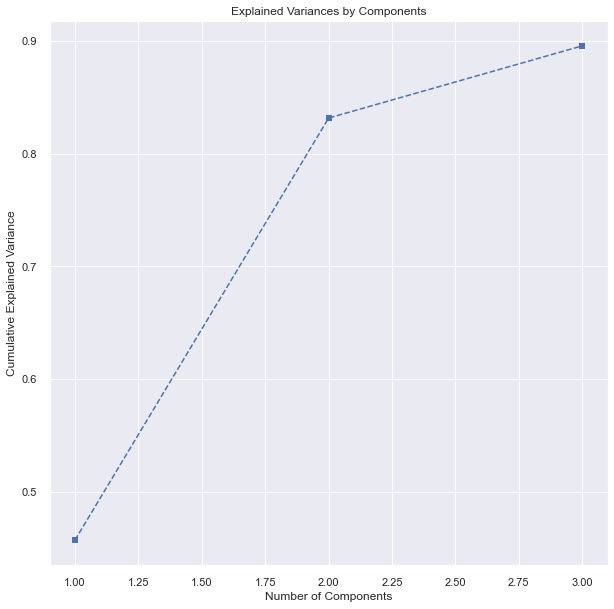

In [224]:
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 4), pca.explained_variance_ratio_.cumsum(), marker="s", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [225]:
subset_pca = pca.transform(data_scaled_df_pca)
subset_pca_df = pd.DataFrame(subset_pca)

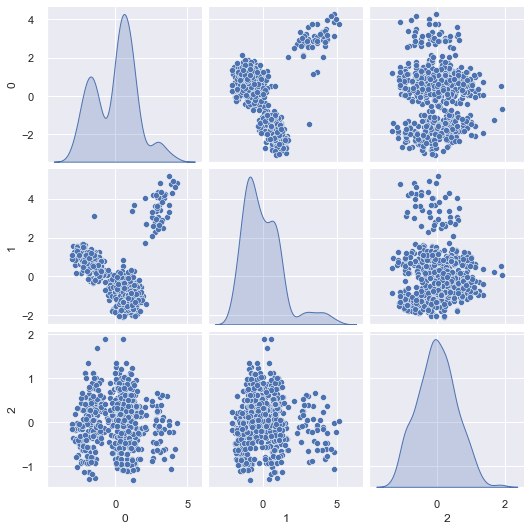

In [226]:
sns.pairplot(subset_pca_df, diag_kind='kde',palette='Set2');

## Hierarchical Clustering on lower-dimensional data

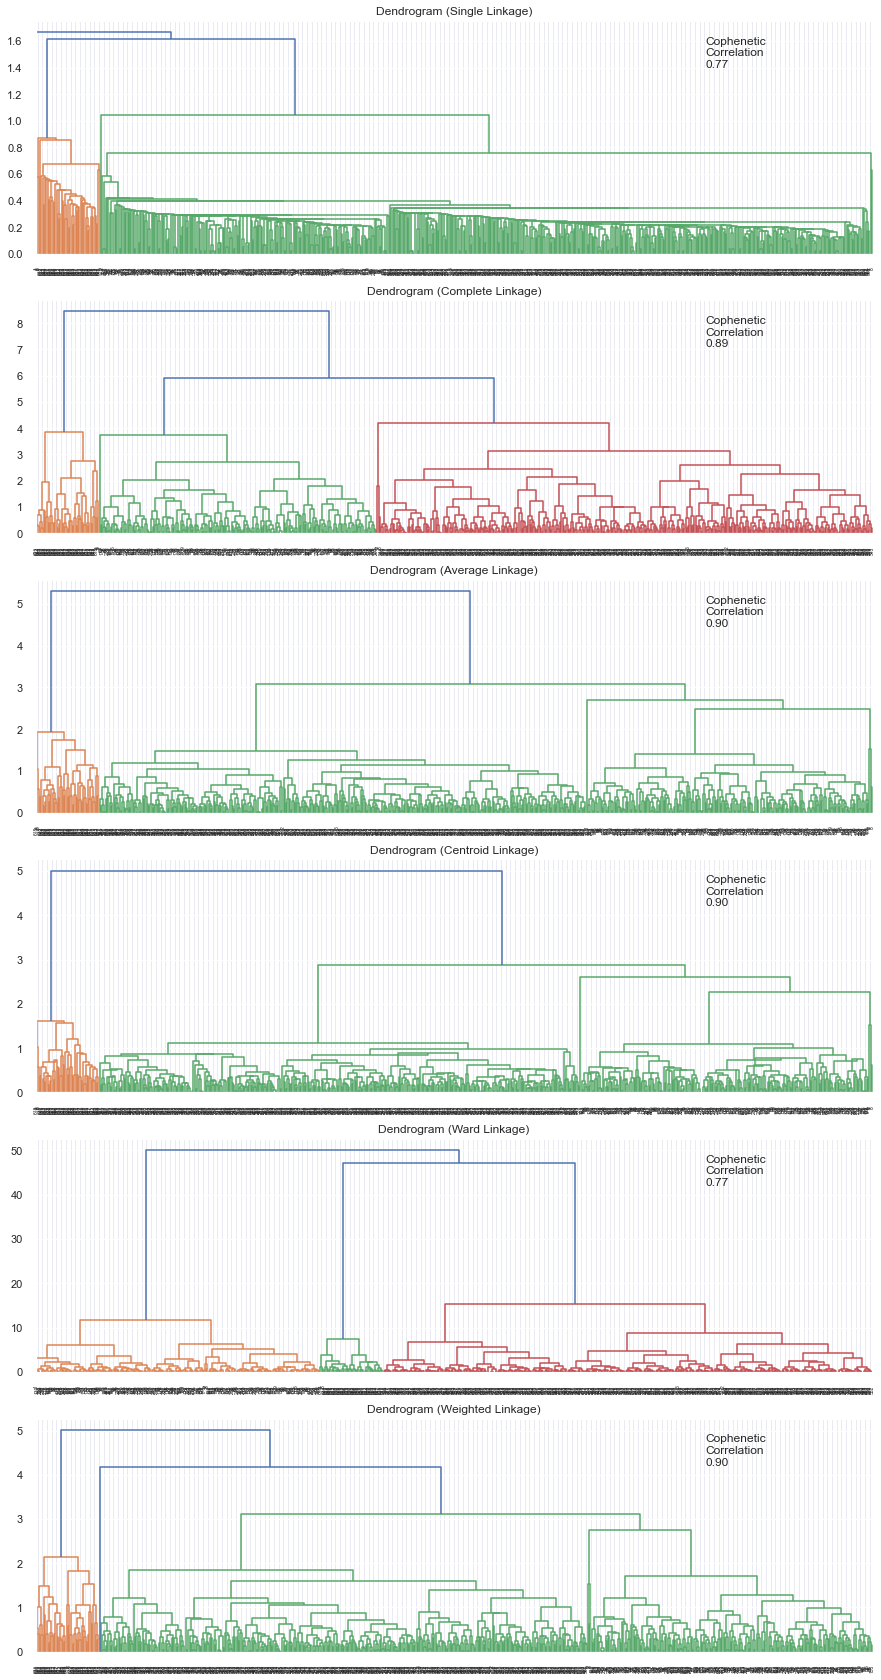

In [227]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_pca_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_pca_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average and centroid linkage method, but I will check with complete linkage as it has more distinct and separated clusters, and a cophenetic correlation of 0.89 (highest being 0.9).
- 3 appears to be the appropriate number of clusters from the dendrogram for complete linkage as well.

In [228]:
hc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
hc_labels = hc.fit_predict(subset_pca)

In [229]:
# adding hierarchical cluster labels to the original dataframe
data_pca = data.drop(['cluster', 'hc_cluster'], axis=1)
data_pca['pca_hc_cluster'] = hc_labels

In [230]:
data_scaled_pca_df = data_scaled_df.drop('hc_cluster', axis=1)
data_scaled_pca_df['pca_hc_cluster'] = hc_labels

## Cluster Profiling

In [231]:
cluster_profile2 = data_pca.groupby('pca_hc_cluster').mean()
cluster_profile2['customer_count'] = (
    data_pca.groupby('pca_hc_cluster')['customer_key'].count().values
)

In [232]:
# let's display cluster profile
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,customer_count
pca_hc_cluster,,,,,,,
0,54847.196931,33508.951407,5.488491,3.460358,1.000000,2.012788,391
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,55308.954338,12168.949772,2.388128,0.926941,3.579909,6.958904,219


In [233]:
pca_df = subset_pca_df.copy()
pca_df['pca_hc_cluster'] = hc_labels

pca_df = pca_df.rename(columns={0:'component_1', 1:'component_2', 2:'component_3'})


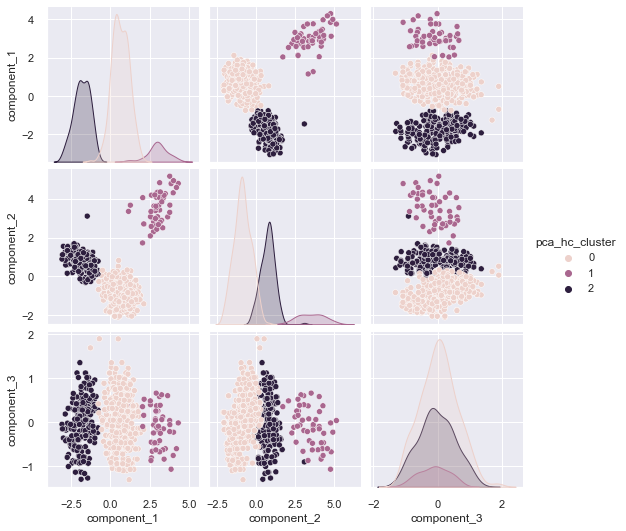

In [234]:
sns.pairplot(pca_df, diag_kind='kde', hue='pca_hc_cluster');

In [235]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= pca_df['component_1'],
    y= pca_df['component_2'],
    z= pca_df['component_3'],
    mode='markers',
     marker=dict(
        color = pca_df['pca_hc_cluster'], 
        size= 20,
        line=dict(
            color= pca_df['pca_hc_cluster'],
            width= 12
        ),
        opacity=0.8
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Component 1'),
            yaxis = dict(title  = 'Component 2'),
            zaxis = dict(title  = 'Component 3')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)

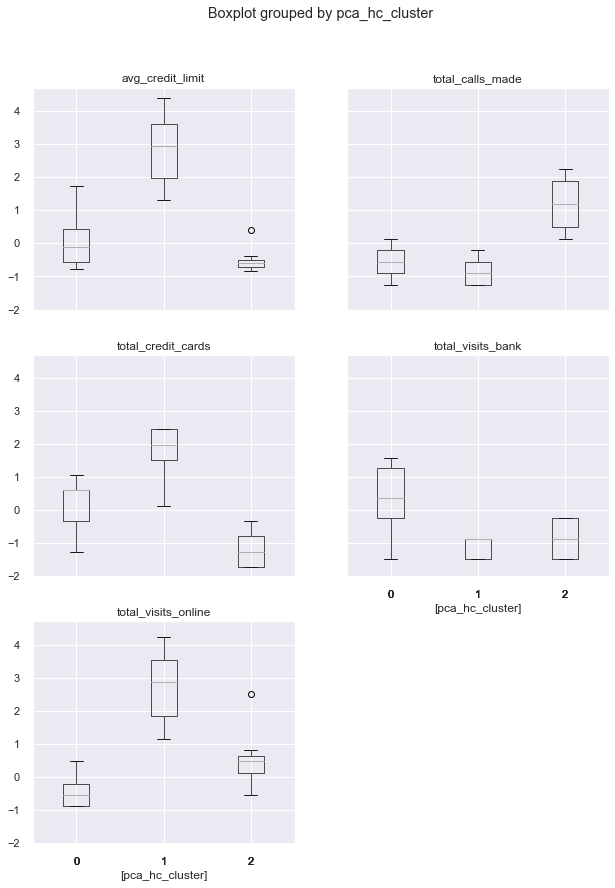

In [236]:
data_scaled_pca_df.boxplot(by='pca_hc_cluster', layout=(3,2), figsize=(10,14));
       

### K-means vs Hierarchical Clustering
LABELS | DESCRIPTION
-------|:------------
 Optimal no. of Cluster| Both gives optimal number of clusters as 3.
 Clsuter grouping| 3 cluster groups given by both algorithms are Cluster 0- In-person, Cluster 1- online, Cluster 2 - phone users.
 Cluster 0| HC clustering algorithms gives cluster 0 with 387 people, and K Means clustering gives 386 people in cluster 0.
 Cluster 1|K means gives 50 people in cluster 1, HC gives 50 people in cluster 1.
 Cluster 2|K means gives 224 people in cluster 2, HC gives 223  people in cluster 2.
 Avg. Credit Limit|Cluster 1 by both algorithm has 14K  as avg. credit limit which is max. among all other clusters.
 No of Credit Cards| Cluster 1 has max. credit card as 8.7, both algorithms gives almost same value.
 Total Visits Online|Both algorithm gives 10.9 as no of online visit for cluster 1 which is highest among all clusters. 
 Total Calls Made|Both algorithm gives 6.87 as no of calls made for cluster 2 which is max. among all clusters. 
 Total Visits Made|Both algorithm gives 3.48 as no of bank visit for cluster 0 which is highest among all clusters. 
 Score| HC gives cophenic coefficient as 0.9 and K Means give silhoutte score as 0.89.

 

In [237]:
# K Menas Cluster Profile
cluster_profile = data.iloc[:,1:].groupby('cluster').mean()
cluster_profile['count_of_customers'] = data.groupby('cluster')['customer_key'].count()
cluster_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,hc_cluster,count_of_customers
cluster,,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,1.991071,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000,50


In [238]:
# HC Cluster Profile
cluster_profile_hc = data.iloc[:,1:].groupby('hc_cluster').mean()
cluster_profile_hc['count_of_customers'] = data.groupby('hc_cluster')['customer_key'].count()
cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='orange')


,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,cluster,count_of_customers
hc_cluster,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


# Actionable Insights and Recommendations

There appears to be three distinct categories of customers:

**0. In-person users:**
- prefer to handle bank transactions in person. 
- They have the medium number of credit cards and the medium available credit. 
- They are also the most active users.
- Since group 0 use the online banking the least, bank should promote online banking more to group 0 in order for them to use it.
 
**1. Online users:** 
- prefer digital transactions. 
- They also have the most credit cards and the highest available credit. 
- Least number of customers falls under this category. 

**2. Phone users:**
- prefer verbally handling transactions. 
- They have fewest credit cards and lowest credit card limit.
- Assuming group 1 who make most phone calls are the customers perceive the support services of the bank 
   poorly. 
- Bank should target group 1 and provide better customers service by conducting feedback survey 
   through phone. 
- Group 1 own less credit card than others, bank should target group 1 to upsell credit cards services.


**Besides, bank should provide higher credit limit to target group 0 where most of the customers are. 
   With higher credit limit,group 0 would be able to spend more.**
 

The customer preferences should be used to contact the customers. Online/phone users will probably prefer email/text notifications, while in-person users prefer mail notifications and upselling (when at the bank location). 

Also, the phone and in-person customers should be reached out to promote online banking.




## Comments:

Group 1 has the highest value for Avg_Credit_Limit,Total_Credit_Cards & Total_visits_online.
Group 1 has the lowest value for Total_visits_bank.
Group 2 has the highest value for Total_calls_made.
Group 2 has the lowest value for Avg_Credit_Limit & Total_Credit_Cards.
Group 0 has the highest value for Total_visits_bank.
Group 0 has the lowest value for Total_visits_online.

Key Questions:
How many different segments of customers are there?

* There are 3 different segements of customers in AllLife Bank credit card customer base.   
How are these segments different from each other?

Using k-means clustering labels as reference: (Group 0-2)

  #### Group 0 ####
 
 * Customers who have average credit limit between 25k and 75k and own credit cards 4-7 max.
 * Customers who most visited bank  2-5 times.
 * Customers who least visit bank online. (0-2 times)
 * Customers who make moderate phone calls (0-4 times)
 * Majority of customers are in this group - 58.4%.
 
  #### Group 1 ####
  
 * Customers who have average credit limit above 75k and own most credit cards 7-10 max.
 * Customers who least visited bank 0-1 times.
 * Customers who most visit bank online . (7-15 times)
 * Customers who make least phone calls (0-2 times)
 * Only 7.3% of customers are in this group.

  #### Group 2 ####
  
 * Customers who have average credit limit below 25k and own credit cards 1-4 max.
 * Customers who seldom visit bank 0-2 times.
 * Customers who visit bank online moderately (1-5 times)
 * Customers who make most phone calls (4-10 times)
 * 34% of customers are in this group.  
 
   
 
  
